<h1>DLPy RNN Text Generation Example</h1>

The following SAS DLPy example performs a text generation task by creating a simple RNN text generation network. The text generation task is to read a text passage and then learn to generate a title for the text passage.

The example uses toy training and test data sets that contain text input and titles. The toy data sets are included in the example code. 

The example assumes that you begin with an active CAS server session as well as pandas, NumPy, and DLPy libraries.

The text classification example also requires a word embedding file used to generate word vectors. Open source pre-trained word embedding files from providers such as Glove and Word2Vec will suffice for example purposes.


<h3>Start and Configure CAS Session</h3>

SAS DLPy requires a running SAS CAS server and Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to CAS. 

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [1]:
# Start a CAS server
import swat
conn = swat.CAS(cashost, casport)

<h3> Load Word Embeddings File </h5>

After initializing CAS and SWAT, import the pandas data analysis library, and then import the location and name of your word embedding file. Word embeddings provides a numeric vector representation for each word/phrase so that recurrent neural networks can work using numbers, rather than words. 

<b>Note:</b> You must provide your own open source word embeddings file. This example uses a file named `word_embeddings.txt`, but the path to and the name of your open-source word embeddings file might vary.

Use `upload_frame()` to load your `word_embeddings.txt` file to the CAS server as a CAS table named `WORD_EMBEDDINGS`.


In [2]:
# load word embeddings: vector representations of words
# this example uses pre-trained word embeddings 
import pandas as pd
embeddings = pd.read_csv('/disk/linux/dlpy/word_embeddings.txt', skipinitialspace=True, index_col=False, delimiter='\t')
conn.upload_frame(embeddings, casout=dict(name='word_embeddings', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table WORD_EMBEDDINGS in caslib CASUSER(ethem_kinginthenorth).
NOTE: The table WORD_EMBEDDINGS has been created in caslib CASUSER(ethem_kinginthenorth) from binary data uploaded to Cloud Analytic Services.


CASTable('WORD_EMBEDDINGS', caslib='CASUSER(ethem_kinginthenorth)')

<h3>Create Training Data Set and Load as CAS Table</h3>

Now create the toy training data set for the text generation example. The toy training data set is comprised of text input. Each observation of the text input contains a text passage (up to several sentences in length), and a title that summarizes the text passage. 

Use data handler and the `addtable()` function to upload `sentiment_data` to the CAS server as a CAS table named  `SENTIMENT_DATA`.

In [3]:
# toy dataset
# for title generation training
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import swat.cas.datamsghandlers as dmh

toytext = StringIO('''text,title
text,title
"Ten more moons have been confirmed to orbit around Jupiter, bringing the planet's total known satellite count to 79. That's the highest number of moons of any planet in the Solar System. And these newly discovered space rocks are giving astronomers insight as to why the Jupiter system looks like it does today.","Astronomers have found a new crop of moons around Jupiter, and one of them is a weirdo"
"A deeply golden, even slightly orange handful of fire rises in the dusk each day and spends the entire night crossing low across the south sky. That imposing mass of celestial flame and fame is none other than the most fascinating of all Earth's fellow worlds, the planet Mars - making its closest approach to Earth in 15 years just two weeks from now.","Enjoying the view of Mars? You ain't seen nothing yet"
"Early this year, NASA announced an updated schedule of commercial crew test flights. According to that schedule, Boeing would launch an uncrewed test flight of its CST-100 Starliner spacecraft in August, followed by a crewed test flight in November. SpaceX would also launch an uncrewed test flight of its Crew Dragon (aka Dragon 2) spacecraft in August, with a crewed test to follow in December. If all went as planned, both companies would be in line to be certified by NASA in early 2019 to carry astronauts on routine ISS missions, ending reliance on Soyuz seats that NASA will lose access to in late 2019.","When will commercial crew launch?"
"There is a new radio telescope up and running based in Karoo, South Africa. The MeerKAT (Karoo Array Telescope), as it's named, operated by the South African Radio Astronomy Observatory, is already producing brilliant images of the super massive black hole that is at our galaxy's center, 25,000 light years away.","A new telescope shows the center of the Milky Way in dazzling, fiery detail"
"Diamonds found in beneath the surface, in a part known as the roots of cratons. These are deep underground and cannot be reached by any current technology. The stash was discovered by studying the sound waves of earthquakes. Diamonds speed up the passing of sound waves, giving away the presence of the precious jewel","Diamonds are NOT so rare after all"
"Even if you stare closely at this seemingly grainy image, you might not be able to tell there's anything to it besides visual noise. But it's not static -- it's a sliver of the distant universe, and every little pinprick of light is a galaxy.","Look Closely -- Every Point of Light in This Image Is a Galaxy"
"Australian scientists have achieved a new milestone in their approach to creating a quantum computer chip in silicon, demonstrating the ability to tune the control frequency of a qubit by engineering its atomic configuration.","Scientists Unlock Signal Frequency Control of Precision Atom Qubits"
"Once again, scientists have shown that Albert Einstein's theory of special relativity is right -- this time, thanks to a particle detector buried deep beneath Antarctica.","Right Again, Einstein: Special Relativity Works Even in Ghostly High-Energy Neutrinos"
''')
handler = dmh.CSV(toytext, skipinitialspace=True)
conn.addtable(table='toytext_training', replace=True, **handler.args.addtable)

[caslib]

 'CASUSER(ethem_kinginthenorth)'

[tableName]

 'TOYTEXT_TRAINING'

[casTable]

 CASTable('TOYTEXT_TRAINING', caslib='CASUSER(ethem_kinginthenorth)')

+ Elapsed: 0.00424s, user: 0.001s, sys: 0.000111s, mem: 0.747mb

<h3>Create Test Data Set and Load as CAS Table</h3>

Now create the toy test data set for the text generation example. The toy data set is comprised of text input. Each observation of the text input contains a text passage (up to several sentences in length), and a title that summarizes the text passage. 

Use data handler and the `addtable()` function to upload `toytext_test` to the CAS server as a CAS table named  `TOYTEXT_TEST`.

In [4]:
 # for title generation scoring
toytext = StringIO('''text,title
"Ten more moons have been confirmed to orbit around Jupiter, bringing the planet's total known satellite count to 79. That's the highest number of moons of any planet in the Solar System. And these newly discovered space rocks are giving astronomers insight as to why the Jupiter system looks like it does today.","Astronomers have found a new crop of moons around Jupiter, and one of them is a weirdo"
"A deeply golden, even slightly orange handful of fire rises in the dusk each day and spends the entire night crossing low across the south sky. That imposing mass of celestial flame and fame is none other than the most fascinating of all Earth's fellow worlds, the planet Mars - making its closest approach to Earth in 15 years just two weeks from now.","Enjoying the view of Mars? You ain't seen nothing yet"
"Early this year, NASA announced an updated schedule of commercial crew test flights. According to that schedule, Boeing would launch an uncrewed test flight of its CST-100 Starliner spacecraft in August, followed by a crewed test flight in November. SpaceX would also launch an uncrewed test flight of its Crew Dragon (aka Dragon 2) spacecraft in August, with a crewed test to follow in December. If all went as planned, both companies would be in line to be certified by NASA in early 2019 to carry astronauts on routine ISS missions, ending reliance on Soyuz seats that NASA will lose access to in late 2019.","When will commercial crew launch?"
''')
handler = dmh.CSV(toytext, skipinitialspace=True)
conn.addtable(table='toytext_test', replace=True, **handler.args.addtable)

[caslib]

 'CASUSER(ethem_kinginthenorth)'

[tableName]

 'TOYTEXT_TEST'

[casTable]

 CASTable('TOYTEXT_TEST', caslib='CASUSER(ethem_kinginthenorth)')

+ Elapsed: 0.00341s, user: 0.000794s, mem: 0.719mb

<h3>Import DLPy Package and Classes</h3>


Now import the DLPy API for the text generation task in the following code. 

First, import the `Sequential` class for network models. Then import the `TextParms` class from DLPy model, the `Bidirectional` class from DLPy blocks, and the `TextGeneration` class from DLPy applications. 

In [5]:
# Import DLPy
import dlpy
from dlpy import Sequential
from dlpy import *
from dlpy.model import TextParms
from dlpy.blocks import Bidirectional
from dlpy.applications import TextGeneration

<h3> Create and Define RNN Text Generation Model </h3>


The environment, data, and tools are defined. Now create a RNN model for text generation and define its architecture. Use DLPy to create a text generation model named `text_generation_model`. The architecture should include 50 neurons per layer and use 4 blocks (3 bi-directional blocks followed by a recurrent layer), as follows:

In [6]:
# create an RNN model for text generation
# this model has 50 neurons in each layer 
# 3 bi-directional blocks and a text generation layer
text_generation_model = TextGeneration(conn, neurons=50, n_blocks=4)

NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


Use the `plot_network()` function to visualize the DAG for the text generation network `text_generation_model` created with DLPy.

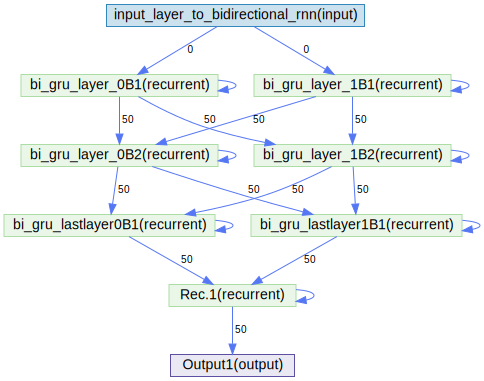

In [7]:
text_generation_model.plot_network()

<h3> Train the RNN Text Generation Model </h3>


Use `fit()` to train the RNN `text_generation_model` using `toytext_training` data. Within `toytext_training`, use the text data in the input field `text` to predict generate text for the target `title`. Use a pre-trained word embeddings file `word_embeddings` and an output embedding file `keyedGlove`. Use a mini-batch size of 1, perform a max of 15 epochs, use a learning rate of 0.01, and use basic log reporting.

In [8]:
# train the text generation model
text_generation_model.fit(data='toytext_training', target='title', inputs=['text'], texts=['text', 'title'],
                          text_parms=TextParms(init_input_embeddings='word_embeddings', 
                                               model_output_embeddings=dict(name='keyedGlove',replace=True)),
                          mini_batch_size=1, 
                          max_epochs=15, 
                          lr=0.01, 
                          log_level=2)

NOTE: Training from scratch.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 177477.
NOTE:  The approximate memory cost is 119.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       2.99 (s).
NOTE:  The total number of threads on each worker is 72.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 72.
NOTE:  Target variable: title
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          0.01           4.456          1     0.08
NOTE:  1          0.01           4.431     0.9889     0.07
NOTE:  2          0.01            4.39     0.9248     0.07
NOTE:  3          0.01           4.356     0.9815     0.07
NOTE:  4          0.01           4.333     0.9444     0.06
NOTE:  5          0.01           4.308     0.9259     0.06

,Descr,Value
0,Model Name,text_generator
1,Model Type,Recurrent Neural Network
2,Number of Layers,9
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,7
9,Number of Weight Parameters,176350


The resuling trained RNN text generation network has 1 input layer, 3 bi-directional blocks, 1 recurrent layer, and 1 output layer. The model network has 190,177 parameters.

<h3> Use Trained RNN Text Generation Model to Score Test Data</h3>


Use `predict()` and `word_embeddings` to score the test data `toytext_test` using the trained RNN model `text_generation_model`. 

Remember that the test data contains only 3 observations.

In [29]:
# score the test data using the trained text generation model `text_generation_model`
# inference will generate a title for the input text passage

text_generation_model.predict(data='toytext_test',
                              text_parms=TextParms(init_input_embeddings='word_embeddings',
                                                   init_output_embeddings='keyedGlove', 
                                                   has_output_term_ids=True))

r = text_generation_model.valid_res_tbl.fetch(to=3)

NOTE: Due to data distribution, miniBatchSize has been limited to 3.


#### Sample input text

In [27]:
r.Fetch['text'][1]

"A deeply golden, even slightly orange handful of fire rises in the dusk each day and spends the entire night crossing low across the south sky. That imposing mass of celestial flame and fame is none other than the most fascinating of all Earth's fellow worlds, the planet Mars - making its closest approach to Earth in 15 years just two weeks from now."

#### Generated title

In [30]:
r.Fetch['title'][1]

"Enjoying the view of Mars? You ain't seen nothing yet"